In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option("display.max_columns", None)
DATA_PATH = Path("../data/raw/raw.csv")

In [2]:
df = pd.read_csv(DATA_PATH, parse_dates=["start_time", "end_time"])
df.head()

,item_id,category,start_price,start_time,duration_hours,end_time,num_bids,end_price,views,watchlist_count
0,1000000,motors,35.72,2025-01-01 00:00:00,24,2025-01-02 00:00:00,26,46.64,303,13
1,1000001,toys,231.84,2025-01-01 06:00:00,120,2025-01-06 06:00:00,20,284.03,244,16
2,1000002,fashion,68.87,2025-01-01 12:00:00,96,2025-01-05 12:00:00,18,82.05,235,13
3,1000003,motors,80.40,2025-01-01 18:00:00,72,2025-01-04 18:00:00,25,102.22,289,13
4,1000004,electronics,317.98,2025-01-02 00:00:00,72,2025-01-05 00:00:00,14,384.37,188,9


In [3]:
df.info()
df.describe()

df.isna().sum()

df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   item_id          1000 non-null   int64         
 1   category         1000 non-null   object        
 2   start_price      1000 non-null   float64       
 3   start_time       1000 non-null   datetime64[ns]
 4   duration_hours   1000 non-null   int64         
 5   end_time         1000 non-null   datetime64[ns]
 6   num_bids         1000 non-null   int64         
 7   end_price        1000 non-null   float64       
 8   views            1000 non-null   int64         
 9   watchlist_count  1000 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(5), object(1)
memory usage: 78.2+ KB


np.int64(0)

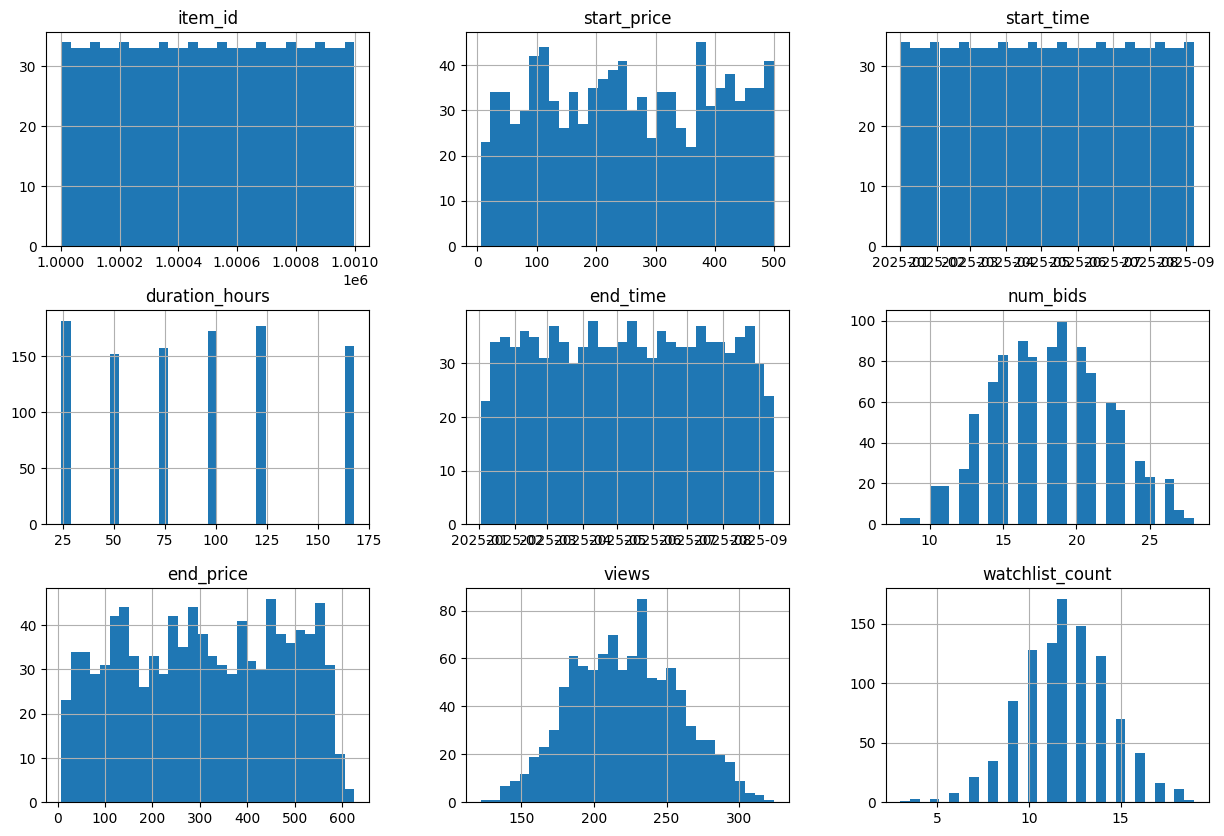

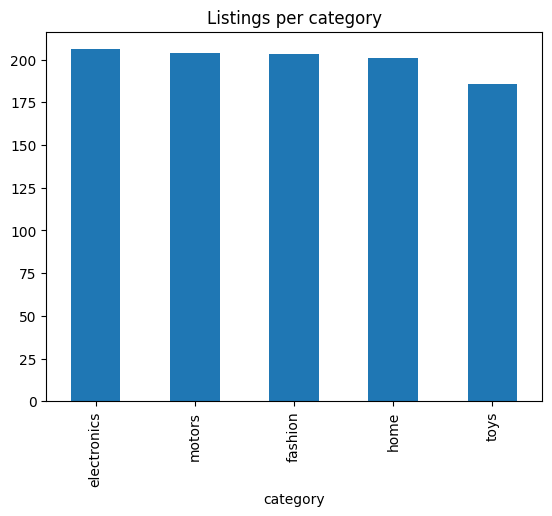

In [4]:
df.hist(bins=30, figsize=(15, 10))
plt.show()

df['category'].value_counts().plot(kind='bar')
plt.title("Listings per category")
plt.show()

In [5]:
def add_time_features(df):
    df = df.copy()
    df['duration_h'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 3600
    df['hour'] = df['start_time'].dt.hour
    df['dow'] = df['start_time'].dt.dayofweek
    df['is_weekend'] = (df['dow'] >= 5).astype(int)
    df['month'] = df['start_time'].dt.month
    return df

df_fe = add_time_features(df)
df_fe.head()

,item_id,category,start_price,start_time,duration_hours,end_time,num_bids,end_price,views,watchlist_count,duration_h,hour,dow,is_weekend,month
0,1000000,motors,35.72,2025-01-01 00:00:00,24,2025-01-02 00:00:00,26,46.64,303,13,24.0,0,2,0,1
1,1000001,toys,231.84,2025-01-01 06:00:00,120,2025-01-06 06:00:00,20,284.03,244,16,120.0,6,2,0,1
2,1000002,fashion,68.87,2025-01-01 12:00:00,96,2025-01-05 12:00:00,18,82.05,235,13,96.0,12,2,0,1
3,1000003,motors,80.40,2025-01-01 18:00:00,72,2025-01-04 18:00:00,25,102.22,289,13,72.0,18,2,0,1
4,1000004,electronics,317.98,2025-01-02 00:00:00,72,2025-01-05 00:00:00,14,384.37,188,9,72.0,0,3,0,1


In [6]:
target = "num_bids"  

features = ["category", "start_price", "hour", "dow", "is_weekend", "duration_h"]

df_sorted = df_fe.sort_values("start_time")
split_idx = int(len(df_sorted) * 0.8)

X_train = df_sorted[features].iloc[:split_idx]
y_train = df_sorted[target].iloc[:split_idx]

X_test = df_sorted[features].iloc[split_idx:]
y_test = df_sorted[target].iloc[split_idx:]

len(X_train), len(X_test)

(800, 200)

In [8]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = mean_squared_error(y_test, y_pred_base) ** 0.5
mape_base = mape(y_test, y_pred_base)

print(f"Naive baseline - MAE: {mae_base:.2f}, RMSE: {rmse_base:.2f}, MAPE: {mape_base:.2f}%")

Naive baseline - MAE: 3.24, RMSE: 3.84, MAPE: 19.39%


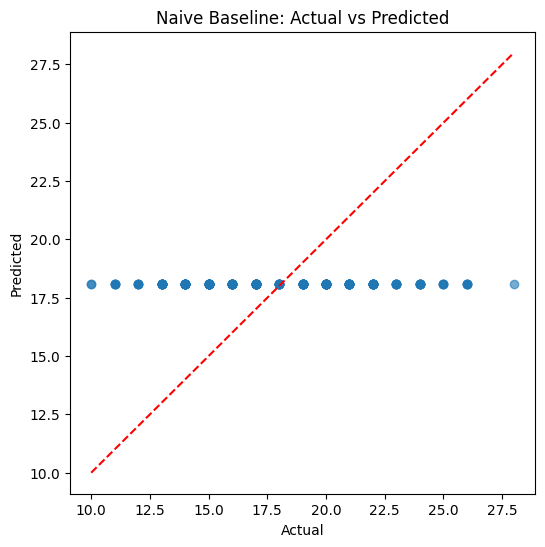

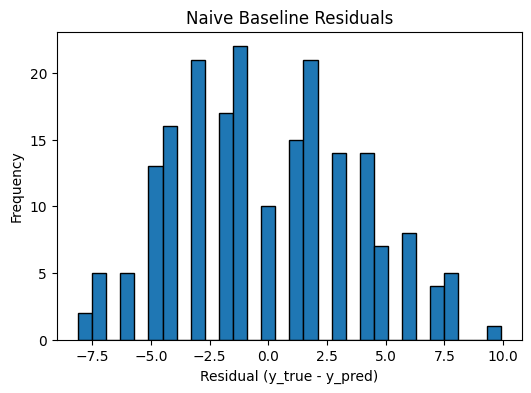

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_base, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Naive Baseline: Actual vs Predicted")
plt.show()

residuals = y_test - y_pred_base
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Naive Baseline Residuals")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Frequency")
plt.show()

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preproc = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["category"])
    ],
    remainder="passthrough"
)

linreg = Pipeline([
    ("prep", preproc),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = mean_squared_error(y_test, y_pred_lin) ** 0.5
mape_lin = mape(y_test, y_pred_lin)

print(f"Linear Regression MAE: {mae_lin:.2f}, RMSE: {rmse_lin:.2f}, MAPE: {mape_lin:.2f}%")

Linear Regression MAE: 1.58, RMSE: 1.85, MAPE: 9.25%


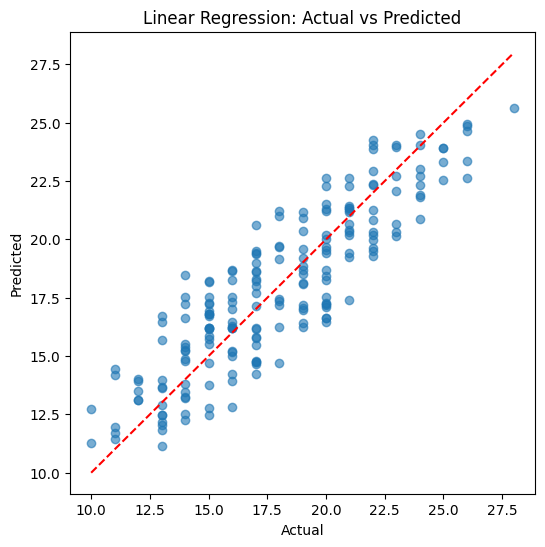

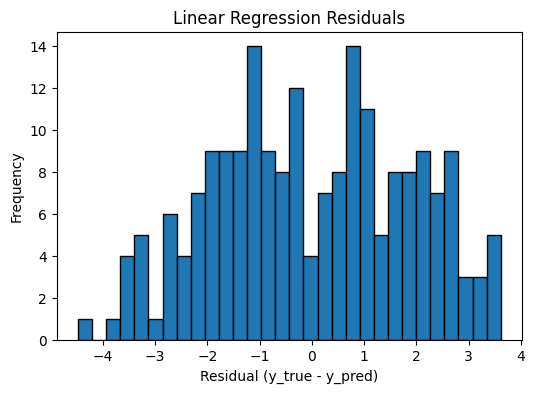

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lin, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()

residuals_lin = y_test - y_pred_lin
plt.figure(figsize=(6,4))
plt.hist(residuals_lin, bins=30, edgecolor='k')
plt.title("Linear Regression Residuals")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Frequency")
plt.show()

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf = Pipeline([
    ("prep", preproc), 
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf) ** 0.5
mape_rf = mape(y_test, y_pred_rf)

print(f"Random Forest - MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, MAPE: {mape_rf:.2f}%")

Random Forest - MAE: 1.45, RMSE: 1.78, MAPE: 8.55%


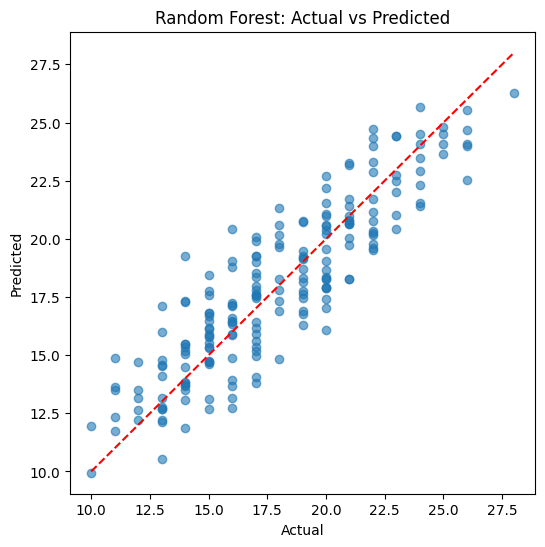

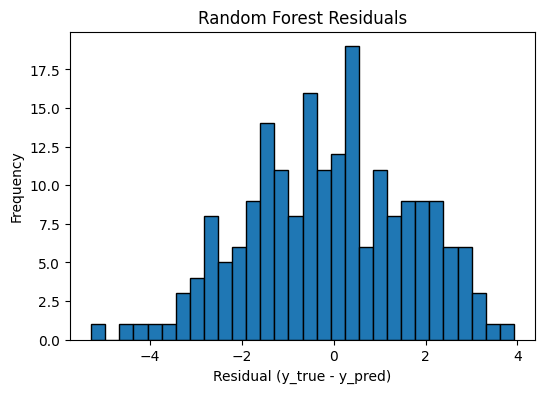

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(6,4))
plt.hist(residuals_rf, bins=30, edgecolor='k')
plt.title("Random Forest Residuals")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Frequency")
plt.show()

In [15]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from pathlib import Path
import pandas as pd

df = pd.read_csv("../data/raw/raw.csv", parse_dates=["start_time", "end_time"])

daily = df.groupby(df["start_time"].dt.date)["num_bids"].sum().reset_index()
daily.columns = ["ds", "y"]  

daily.head()

,ds,y
0,2025-01-01,89
1,2025-01-02,71
2,2025-01-03,70
3,2025-01-04,73
4,2025-01-05,65


In [17]:
from prophet import Prophet

m = Prophet()
m.fit(daily)

C:\Users\mirun\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
17:13:34 - cmdstanpy - INFO - Chain [1] start processing
17:13:35 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
275,2025-10-03,71.488889,61.751569,81.045082
276,2025-10-04,72.181713,62.365446,81.283291
277,2025-10-05,70.073266,60.950468,79.196386
278,2025-10-06,71.252523,61.140464,80.763397
279,2025-10-07,71.223553,61.518555,80.586175


In [21]:
!pip install plotly

     ---------------------------------------- 9.8/9.8 MB 8.3 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

plt.rcParams["figure.figsize"] = (8, 5)

In [28]:
df = pd.read_csv("../data/raw/raw.csv", parse_dates=["start_time", "end_time"])

daily = (
    df.groupby(df["start_time"].dt.floor("D"))["num_bids"]
      .sum()
      .reset_index()
      .rename(columns={"start_time": "ds", "num_bids": "y"})
      .sort_values("ds")
      .reset_index(drop=True)
)

daily.head(), daily.tail()

(          ds   y
 0 2025-01-01  89
 1 2025-01-02  71
 2 2025-01-03  70
 3 2025-01-04  73
 4 2025-01-05  65,
             ds   y
 245 2025-09-03  66
 246 2025-09-04  75
 247 2025-09-05  76
 248 2025-09-06  76
 249 2025-09-07  69)

In [29]:
H = 30  
train = daily.iloc[:-H].copy()
test  = daily.iloc[-H:].copy()

m = Prophet(weekly_seasonality=True, daily_seasonality=True, yearly_seasonality=False)
m.fit(train)

future = m.make_future_dataframe(periods=H, freq="D")
fcst = m.predict(future)

eval_df = (
    fcst[["ds","yhat","yhat_lower","yhat_upper"]]
    .merge(daily[["ds","y"]], on="ds", how="left")
    .iloc[-H:] 
)
eval_df.head()

17:24:54 - cmdstanpy - INFO - Chain [1] start processing
17:24:54 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y
220,2025-08-09,72.012149,62.749237,80.668913,68
221,2025-08-10,69.177316,59.844375,78.436569,84
222,2025-08-11,72.340717,63.054368,81.426138,61
223,2025-08-12,70.572238,60.594919,79.832404,87
224,2025-08-13,71.305742,62.240621,79.991753,87


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = y_true != 0
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100)

mae  = mean_absolute_error(eval_df["y"], eval_df["yhat"])
rmse = mean_squared_error(eval_df["y"], eval_df["yhat"]) ** 0.5
mape_val = mape(eval_df["y"], eval_df["yhat"])

print(f"Prophet (daily total num_bids) - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape_val:.2f}%")

Prophet (daily total num_bids) - MAE: 6.47, RMSE: 8.28, MAPE: 9.08%


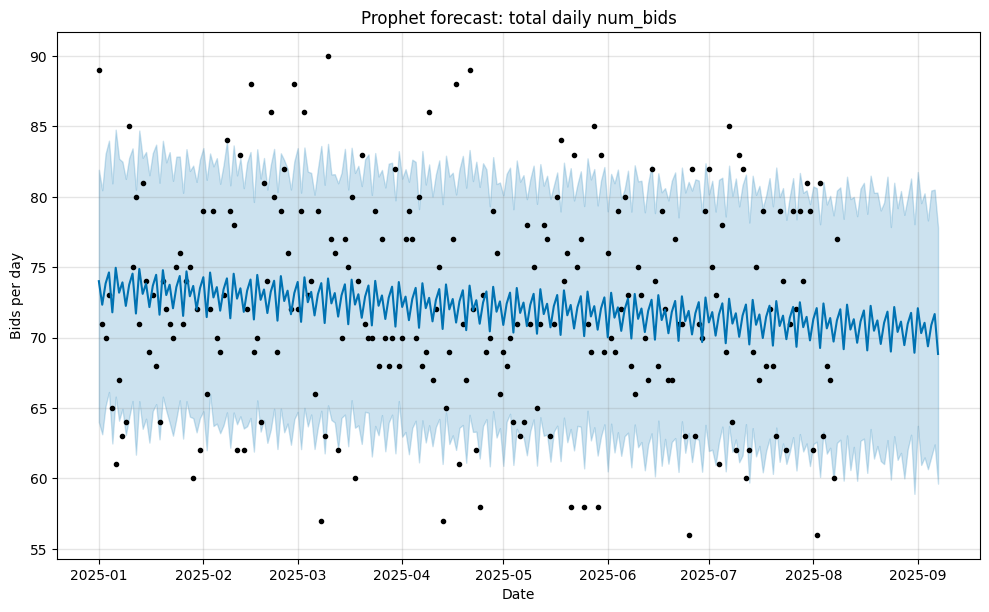

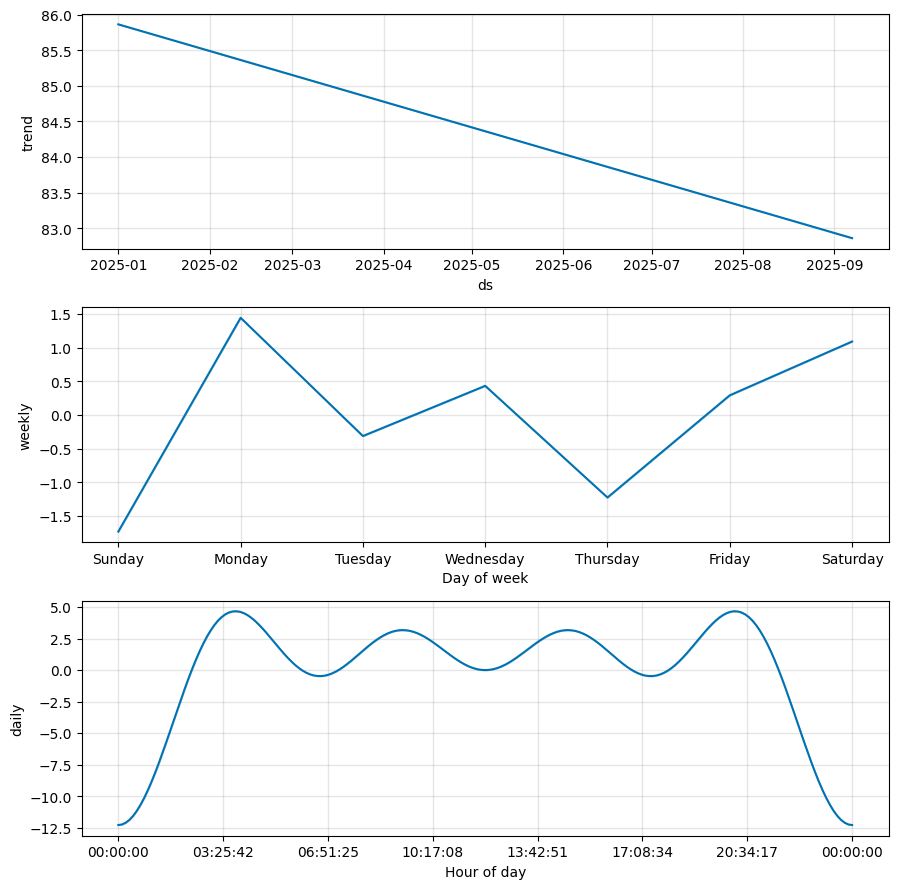

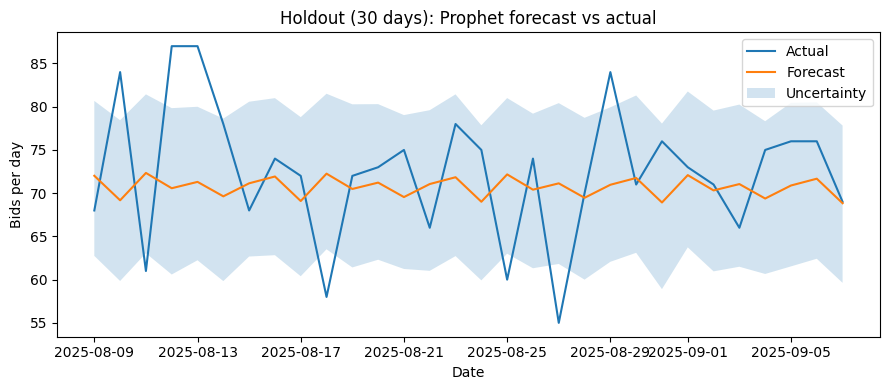

In [31]:
fig1 = m.plot(fcst)
plt.title("Prophet forecast: total daily num_bids")
plt.xlabel("Date"); plt.ylabel("Bids per day")
plt.show()

fig2 = m.plot_components(fcst)
plt.show()

plt.figure(figsize=(9,4))
plt.plot(eval_df["ds"], eval_df["y"], label="Actual")
plt.plot(eval_df["ds"], eval_df["yhat"], label="Forecast")
plt.fill_between(eval_df["ds"], eval_df["yhat_lower"], eval_df["yhat_upper"], alpha=0.2, label="Uncertainty")
plt.title(f"Holdout ({H} days): Prophet forecast vs actual")
plt.xlabel("Date"); plt.ylabel("Bids per day"); plt.legend()
plt.tight_layout(); plt.show()

,Model,MAE,RMSE,MAPE
0,Random Forest,1.45,1.78,8.55%
1,Prophet (daily demand),6.47,8.28,9.08%
2,Linear Regression,1.58,1.85,9.25%
3,Naive baseline,3.24,3.84,19.39%


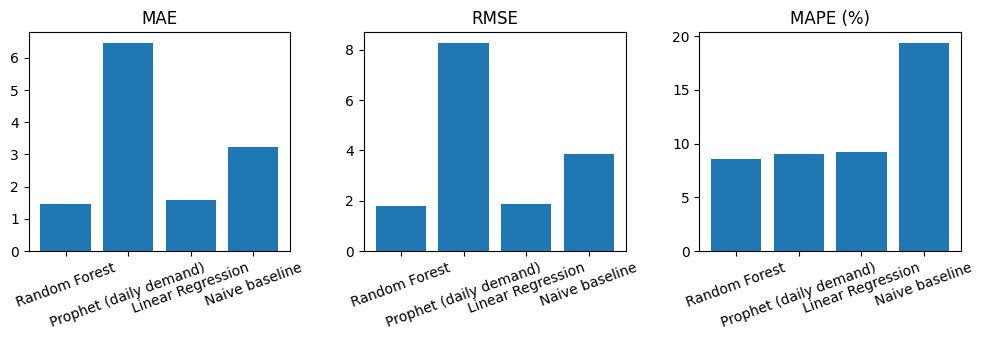

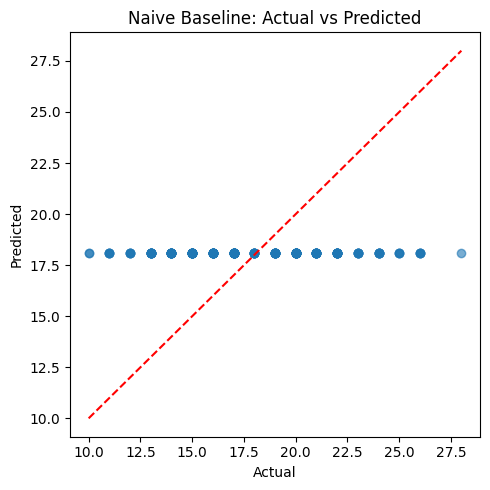

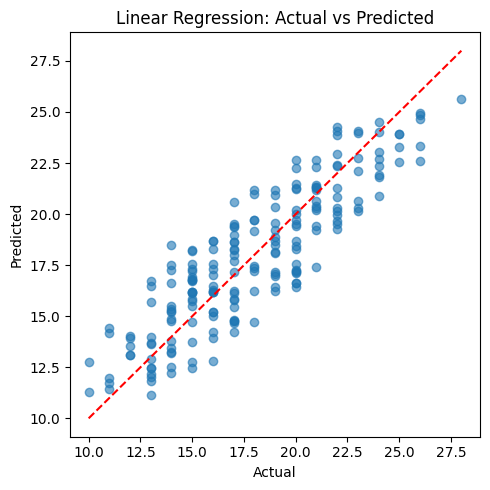

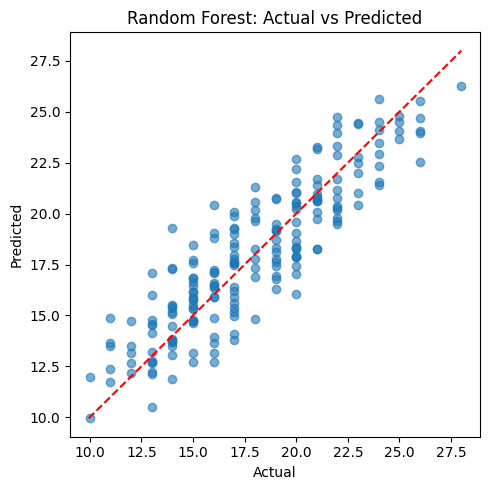

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

os.makedirs("reports/figs", exist_ok=True)

def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = y_true != 0
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100)

rows = []
rows.append({
    "Model": "Naive baseline",
    "MAE": mean_absolute_error(y_test, y_pred_base),
    "RMSE": mean_squared_error(y_test, y_pred_base)**0.5,
    "MAPE": mape(y_test, y_pred_base),
})
rows.append({
    "Model": "Linear Regression",
    "MAE": mean_absolute_error(y_test, y_pred_lin),
    "RMSE": mean_squared_error(y_test, y_pred_lin)**0.5,
    "MAPE": mape(y_test, y_pred_lin),
})
rows.append({
    "Model": "Random Forest",
    "MAE": mean_absolute_error(y_test, y_pred_rf),
    "RMSE": mean_squared_error(y_test, y_pred_rf)**0.5,
    "MAPE": mape(y_test, y_pred_rf),
})

try:
    rows.append({
        "Model": "Prophet (daily demand)",
        "MAE": mae, "RMSE": rmse, "MAPE": mape_val
    })
except NameError:
    pass 

metrics_df = pd.DataFrame(rows).sort_values("MAPE").reset_index(drop=True)

metrics_df.to_csv("reports/metrics.csv", index=False)

display(metrics_df.style.format({"MAE":"{:.2f}","RMSE":"{:.2f}","MAPE":"{:.2f}%"}))

plt.figure(figsize=(10,3.5))
plt.subplot(1,3,1)
plt.bar(metrics_df["Model"], metrics_df["MAE"])
plt.title("MAE"); plt.xticks(rotation=20)

plt.subplot(1,3,2)
plt.bar(metrics_df["Model"], metrics_df["RMSE"])
plt.title("RMSE"); plt.xticks(rotation=20)

plt.subplot(1,3,3)
plt.bar(metrics_df["Model"], metrics_df["MAPE"])
plt.title("MAPE (%)"); plt.xticks(rotation=20)

plt.tight_layout()
plt.savefig("reports/figs/metrics_bars.png", dpi=300)
plt.show()

def scatter_ap(y_true, y_pred, title, fname):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.6)
    lo, hi = float(min(y_true.min(), y_pred.min())), float(max(y_true.max(), y_pred.max()))
    plt.plot([lo, hi], [lo, hi], 'r--')
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    plt.show()

scatter_ap(y_test, y_pred_base, "Naive Baseline: Actual vs Predicted", "reports/figs/scatter_baseline.png")
scatter_ap(y_test, y_pred_lin, "Linear Regression: Actual vs Predicted", "reports/figs/scatter_linear.png")
scatter_ap(y_test, y_pred_rf, "Random Forest: Actual vs Predicted", "reports/figs/scatter_rf.png")


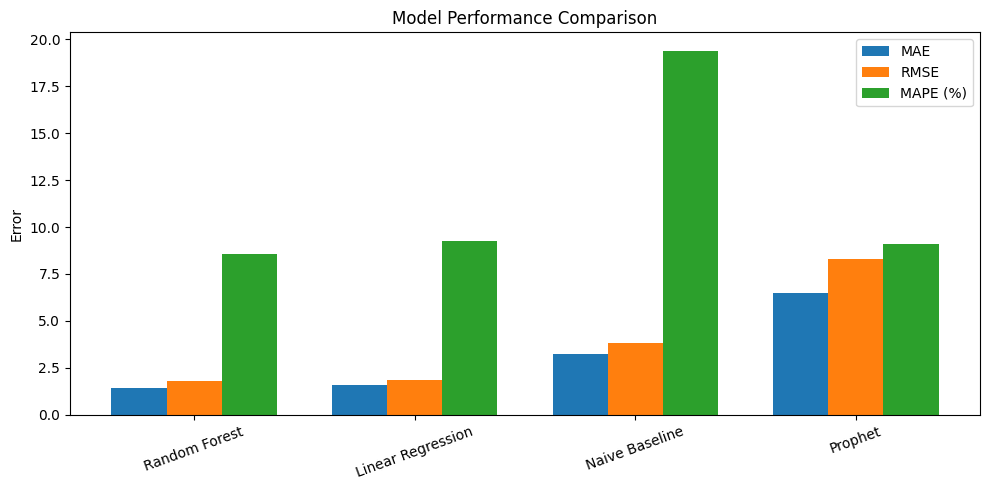

In [1]:
import matplotlib.pyplot as plt

models = ["Random Forest", "Linear Regression", "Naive Baseline", "Prophet"]
mae_vals = [1.45, 1.58, 3.24, 6.47]
rmse_vals = [1.78, 1.85, 3.84, 8.28]
mape_vals = [8.55, 9.25, 19.39, 9.08]

x = range(len(models))

plt.figure(figsize=(10,5))
plt.bar(x, mae_vals, width=0.25, label="MAE")
plt.bar([i+0.25 for i in x], rmse_vals, width=0.25, label="RMSE")
plt.bar([i+0.5 for i in x], mape_vals, width=0.25, label="MAPE (%)")

plt.xticks([i+0.25 for i in x], models, rotation=20)
plt.ylabel("Error")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()

## Model Comparison Results

I evaluated four different models to predict the number of bids:

| Model                         | MAE   | RMSE  | MAPE   |
|--------------------------------|-------|-------|--------|
| Random Forest                  | 1.45  | 1.78  | 8.55%  |
| Linear Regression              | 1.58  | 1.85  | 9.25%  |
| Naive Baseline                 | 3.24  | 3.84  | 19.39% |
| Prophet (daily total num_bids) | 6.47  | 8.28  | 9.08%  |

### Interpretation
- **Random Forest** achieved the lowest MAE, RMSE, and MAPE, which means it produced the most accurate and consistent predictions.
- **Linear Regression** came close, suggesting that even a relatively simple model can perform well if the data is structured and features are informative.
- **Naive Baseline** lagged far behind, confirming that the dataset has learnable patterns beyond a simple average.
- **Prophet** performed reasonably well in terms of MAPE for daily aggregated predictions but had higher MAE and RMSE, likely due to smoothing effects in trend/seasonality modeling.

### Conclusion
For item-level forecasting, Random Forest is the best choice in this setup. Prophet remains useful for high-level demand forecasting, helping identify patterns like weekly seasonality that could inform listing strategies.